In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hlxon_hdf5io import *
from scipy.spatial.transform import Rotation
from filters.HelixonKalmanFilter import *
from metrics import *

In [2]:
def quaternion_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2
    z = w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2
    return np.array([w, x, y, z])

In [3]:
def angular_distance(b, a):
    return np.where(np.abs(b-a) < 180, b-a, np.where((b-a) > 0, 360 - (b-a), 360 + (b-a)))

# Load data


In [4]:
# get data from hdf5
raw_timestamp, raw_9dof, raw_rpy, raw_bno, raw_bmp, raw_pressure, wifidata, gt_timestamp, gt_position, gt_orientation = readHDF5('RandomUDP3')

# p0 is first real pressure measurement
p0 = max(raw_pressure)

# convenience
X, Y, Z = 0, 1, 2
N = len(raw_timestamp)

# get sensor data
araw = np.array(raw_9dof[:, :3])
gyro = np.array(raw_9dof[:, 3:6])
magn = np.array(raw_9dof[:, 6:])
pres = np.array(raw_pressure).reshape((-1, 1))
alpha = 1.16e-4
ts = np.array(raw_timestamp)*1e-6
gt_timestamp = np.array(gt_timestamp)*1e-6


# Preprocess Data

In [5]:

rots = np.array([Rotation.from_quat(q).as_euler('xyz', degrees=True) for q in gt_orientation]) # change quat gt rots to euler
rots -= rots[0] # normalize to initial rot
rots = rots[:, ::-1] # reverse order of xyz to match ndof
rots[:, X] *= -1 # invert X rotations to match ndof
rots = np.array([Rotation.from_euler('xyz', r, degrees=True).as_euler('xyz', degrees=True) for r in rots])

# lerp rots
N = len(rots)

# interpolate over timestamps
lerped_rotations = np.zeros((N, 3))
for i in range(N):
    if gt_timestamp[i] in ts:
        lerped_rotations[i] = raw_rpy[np.argmax(ts == gt_timestamp[i])]
    else:
        # lerp
        ix_2 = np.argmax(ts > gt_timestamp[i])
        ix_1 = ts.shape[0] - np.argmax(np.flip(ts, axis=0) < gt_timestamp[i]) - 1

        lerped_rotations[i] = raw_rpy[ix_1] + (gt_timestamp[i]-ts[ix_1])*angular_distance(raw_rpy[ix_2], raw_rpy[ix_1])/(ts[ix_2] - ts[ix_1] + 1e-10)

rpy = lerped_rotations

# Synchronize both signals
The signals were synchronized using the LED method discussed in the paper, however this wasn't perfect. To account for this in our evaluation, an correlation of the signal was done to determine the time delay introduced by the calibration error.

In [6]:
# interpolate over time to create single sampling rate
fs = len(gt_timestamp) / gt_timestamp[-1]
CNT = int(fs*gt_timestamp[-1])
unified_ts = np.linspace(0, gt_timestamp[-1], CNT)

lerpedrpy = np.zeros((CNT, 3))
lerpedrots = np.zeros((CNT, 3))

for i in range(CNT):
    if unified_ts[i] in gt_timestamp:
        lerpedrpy[i] = rpy[np.argmax(gt_timestamp == unified_ts[i])]
        lerpedrots[i] = rots[np.argmax(gt_timestamp == unified_ts[i])]

    else:
        # lerp
        ix_2 = np.argmax(gt_timestamp > unified_ts[i])
        ix_1 = gt_timestamp.shape[0] - np.argmax(np.flip(gt_timestamp, axis=0) < unified_ts[i]) - 1

        lerpedrpy[i] = rpy[ix_1] + (unified_ts[i]-gt_timestamp[ix_1])*angular_distance(rpy[ix_2], rpy[ix_1])/(gt_timestamp[ix_2] - gt_timestamp[ix_1] + 1e-10)
        lerpedrots[i] = rots[ix_1] + (unified_ts[i]-gt_timestamp[ix_1])*angular_distance(rots[ix_2], rots[ix_1])/(gt_timestamp[ix_2] - gt_timestamp[ix_1] + 1e-10)

rots = lerpedrots
rpy = lerpedrpy

Delay is -12.003992015968151 samples or -2.386518778443131 seconds


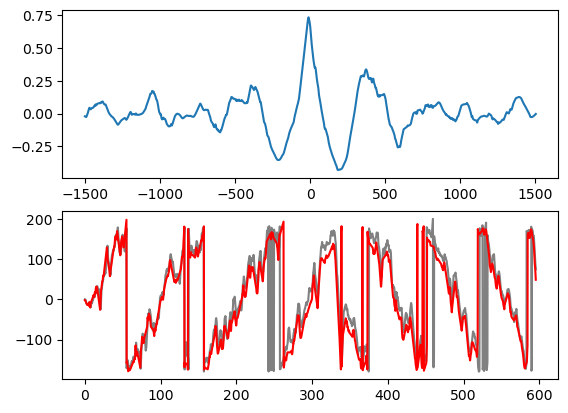

In [7]:
from scipy import signal

fs = len(unified_ts) / unified_ts[-1]
n = len(rpy[:, X])

corr = signal.correlate(rots[:, X], rpy[:, X], mode='same') / np.sqrt(signal.correlate(rpy[:, X], rpy[:, X], mode='same')[int(n/2)] * signal.correlate(rots[:, X], rots[:, X], mode='same')[int(n/2)])

delay_arr = np.linspace(-0.5*n, 0.5*n, n)
delay = delay_arr[np.argmax(corr)]

ix = int(delay)
if ix > 0:
    rots = rots[ix:]
    rpy = rpy[:-ix]
    unified_ts = unified_ts[:-ix]
else:
    rpy = rpy[-ix:]
    rots = rots[:ix]
    unified_ts = unified_ts[:ix]
print(f'Delay is {delay} samples or {delay/fs} seconds')
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(delay_arr, corr)

ax2.plot(unified_ts, rots[:, X], color='gray')
ax2.plot(unified_ts, rpy[:, X], color='red') 
plt.show()


# Extract Window with Largest Error

-145.1345950090522 127.40252429234494 87.46288069860287


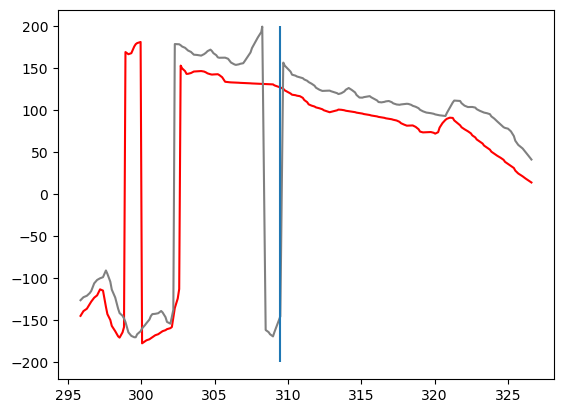

In [8]:
ixmax = np.argmax(np.linalg.norm(angular_distance(rpy, rots), axis=1))
print(rots[ixmax, X], rpy[ixmax, X], angular_distance(rpy[ixmax], rots[ixmax])[X])
windowsize = 200
window = (max(0, ixmax-windowsize//2), min(len(rpy)-1, ixmax+windowsize//2))

# plot positions as functions of time
fig = plt.figure()
ax = plt.axes()
ax.plot(gt_timestamp[window[0]:window[1]], rpy[window[0]:window[1], X], color='red')
ax.plot(gt_timestamp[window[0]:window[1]], rots[window[0]:window[1], X], color='gray')
ax.vlines(gt_timestamp[ixmax], -200, 200)
plt.show()


# Evaluate Performance

In [9]:
# Evaluate
print('-------------Shortest Angle Errors (norm of XYZ error)-------------')
# median angle error
ade = np.median(np.linalg.norm(np.abs(angular_distance(rpy, rots)), axis=1))
print(f'angle median angle error: {ade}')

# average angle error
ade = np.mean(np.linalg.norm(np.abs(angular_distance(rpy, rots)), axis=1))
print(f'angle average angle error: {ade}')

# max angle error
mde = np.linalg.norm(np.abs(angular_distance(rpy, rots)), axis=1).max()
print(f'angle max angle error: {mde}')

# root mean squared error over angles
msde = np.sqrt(np.mean(np.linalg.norm(np.abs(angular_distance(rpy, rots)), axis=1)**2))
print(f'angle root mean squared angle error: {msde}')

print('-------------Individual Angle Component Errors-------------')
# median angle error
ade = np.median(np.abs(angular_distance(rpy, rots)), axis=0)
print(f'angle median angle error: {ade}')

# average angle error
ade = np.mean(np.abs(angular_distance(rpy, rots)), axis=0)
print(f'angle average angle error: {ade}')

# max angle error
mde = (np.abs(angular_distance(rpy, rots))).max(axis=0)
print(f'angle max angle error: {mde}')

# root mean squared error over angles
msde = np.sqrt(np.mean((np.abs(angular_distance(rpy, rots)))**2, axis=0))
print(f'angle root mean squared angle error: {msde}')


-------------Shortest Angle Errors (norm of XYZ error)-------------
angle median angle error: 20.188145043268637
angle average angle error: 21.32146706588696
angle max angle error: 87.63580969881872
angle root mean squared angle error: 24.706313801573522
-------------Individual Angle Component Errors-------------
angle median angle error: [19.90217169  1.55517335  1.44903599]
angle average angle error: [20.84938587  1.92774874  1.79520922]
angle max angle error: [87.4628807  11.49779853  8.73989538]
angle root mean squared angle error: [24.47304769  2.47720093  2.30983856]


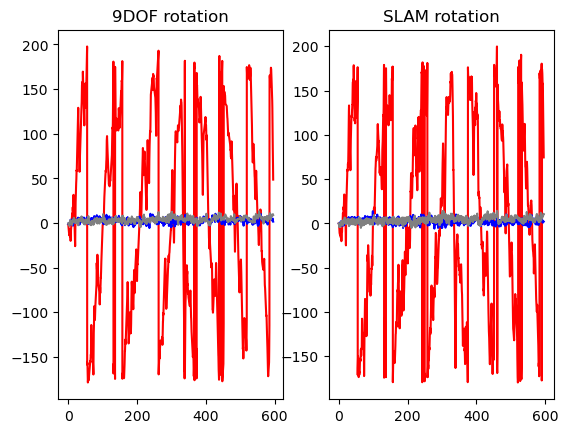

In [10]:

# plot positions as functions of time
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('9DOF rotation')
ax1.plot(unified_ts, rpy[:, X], color='red')
ax1.plot(unified_ts, rpy[:, Y], color='blue')
ax1.plot(unified_ts, rpy[:, Z], color='gray')

ax2.set_title('SLAM rotation')
ax2.plot(unified_ts, rots[:, X], color='red')
ax2.plot(unified_ts, rots[:, Y], color='blue')
ax2.plot(unified_ts, rots[:, Z], color='gray')
plt.show()